In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/DDU+CE"

/content/drive/MyDrive/DDU+CE


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.gray()


CE_dir = '_testset_results/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels = torch.load(CE_dir + f'orig_batch_100_y.pt').to(device)
labels_exp = torch.load(CE_dir + f'orig_batch_100_y.pt').unsqueeze(1).expand(100, 10)
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())

batch_size = 100

print('device: ', device)

device:  cpu


<Figure size 432x288 with 0 Axes>

# Analysis

In [4]:
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())
originals = torch.load(CE_dir + f'orig_batch_{batch_size}_X.pt')
orig_exp = originals.expand(100,10,28,28)

GAN = {}
iter = {}
im = {}
L0 = {}
L1 = {}
mask = {}

### DeDUCE

In [5]:
method = 'DeDUCE'

coeff = 4
m = 'm6'
cl = 'cl1'
max_iter = 700
p = 'p1'

GAN[method] = torch.tensor(np.load(CE_dir + f'DeDUCE_AGAN_c{int(coeff)}{m}{cl}{p}.npy'))#.reshape(100,10))
GAN_originals = GAN[method][labels_exp == targets].unsqueeze(1).expand(batch_size, 10)
iter[method] = torch.load(CE_dir + f'DeDUCE_iter_c{int(coeff)}{m}{cl}{p}.pt')
im[method] = torch.load(CE_dir + f'DeDUCE_arr_c{int(coeff)}{m}{cl}{p}.pt').reshape(100,10,28,28)
L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

### JSMA

In [6]:
method = 'JSMA'

coeff = 0
max_iter = 700
p = 'p1'

GAN[method] = torch.tensor(np.load(CE_dir + f'{method}_AGAN_c{int(coeff)}{p}.npy'))#.reshape(100,10))
iter[method] = torch.load(CE_dir + f'{method}_iter_c{int(coeff)}{p}.pt')
im[method] = torch.load(CE_dir + f'{method}_arr_c{int(coeff)}{p}.pt').reshape(100,10,28,28) #.permute(0,2,1)
L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

### VLK

In [7]:
method = 'VLK'

coeff = 0
max_iter = float('inf')

GAN[method] = torch.tensor(np.load(CE_dir + f'{method}_AGAN_c{int(coeff)}.npy'))#.reshape(100,10))
#iter[method] = torch.load(CE_dir + f'{method}_iter_{v}batch_c{int(coeff)}.pt')
im[method] = torch.load(CE_dir + f'{method}_arr_c{int(coeff)}.pt').reshape(100,10,28,28)
L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
mask[method] = (targets != labels_exp) & (im['VLK'].sum((2,3)) != 0) # filter out where not converged

### REVISE

In [8]:
method = 'REVISE'

coeff = 0
max_iter = 50000
lam = 0
step_size = -5

load_method = f'REVISE_l{lam}s{step_size}'

GAN[method] = torch.tensor(np.load(CE_dir + f'{load_method}_AGAN_c{int(coeff)}.npy'))#.reshape(100,10))
iter[method] = torch.load(CE_dir + f'{load_method}_iter_c{int(coeff)}.pt')
im[method] = torch.load(CE_dir + f'{load_method}_arr_c{int(coeff)}.pt').reshape(100,10,28,28)
L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

In [9]:
mask_all = mask['DeDUCE'] & mask['JSMA'] & mask['REVISE'] & mask['VLK'] # compare on same examples

# show examples

[7.43, 16.13, 3.8, 15.04, 10.53, 3.06, 12.11, 12.08, 13.9, 14.58]
[18.7  16.13 12.56 17.04 19.94 12.98 33.12 42.69 21.16 25.64]
[20.47 13.14 10.85 17.16 13.39 13.04 23.64 17.41 27.79 22.36]
[4.464e+01 2.000e-02 1.100e+01 2.661e+01 2.084e+01 2.491e+01 2.930e+01
 1.805e+01 2.135e+01 3.748e+01]
[0.000e+00 1.870e+01 0.000e+00 2.604e+01 3.037e+01 1.000e-02 0.000e+00
 1.816e+01 2.211e+01 2.124e+01]


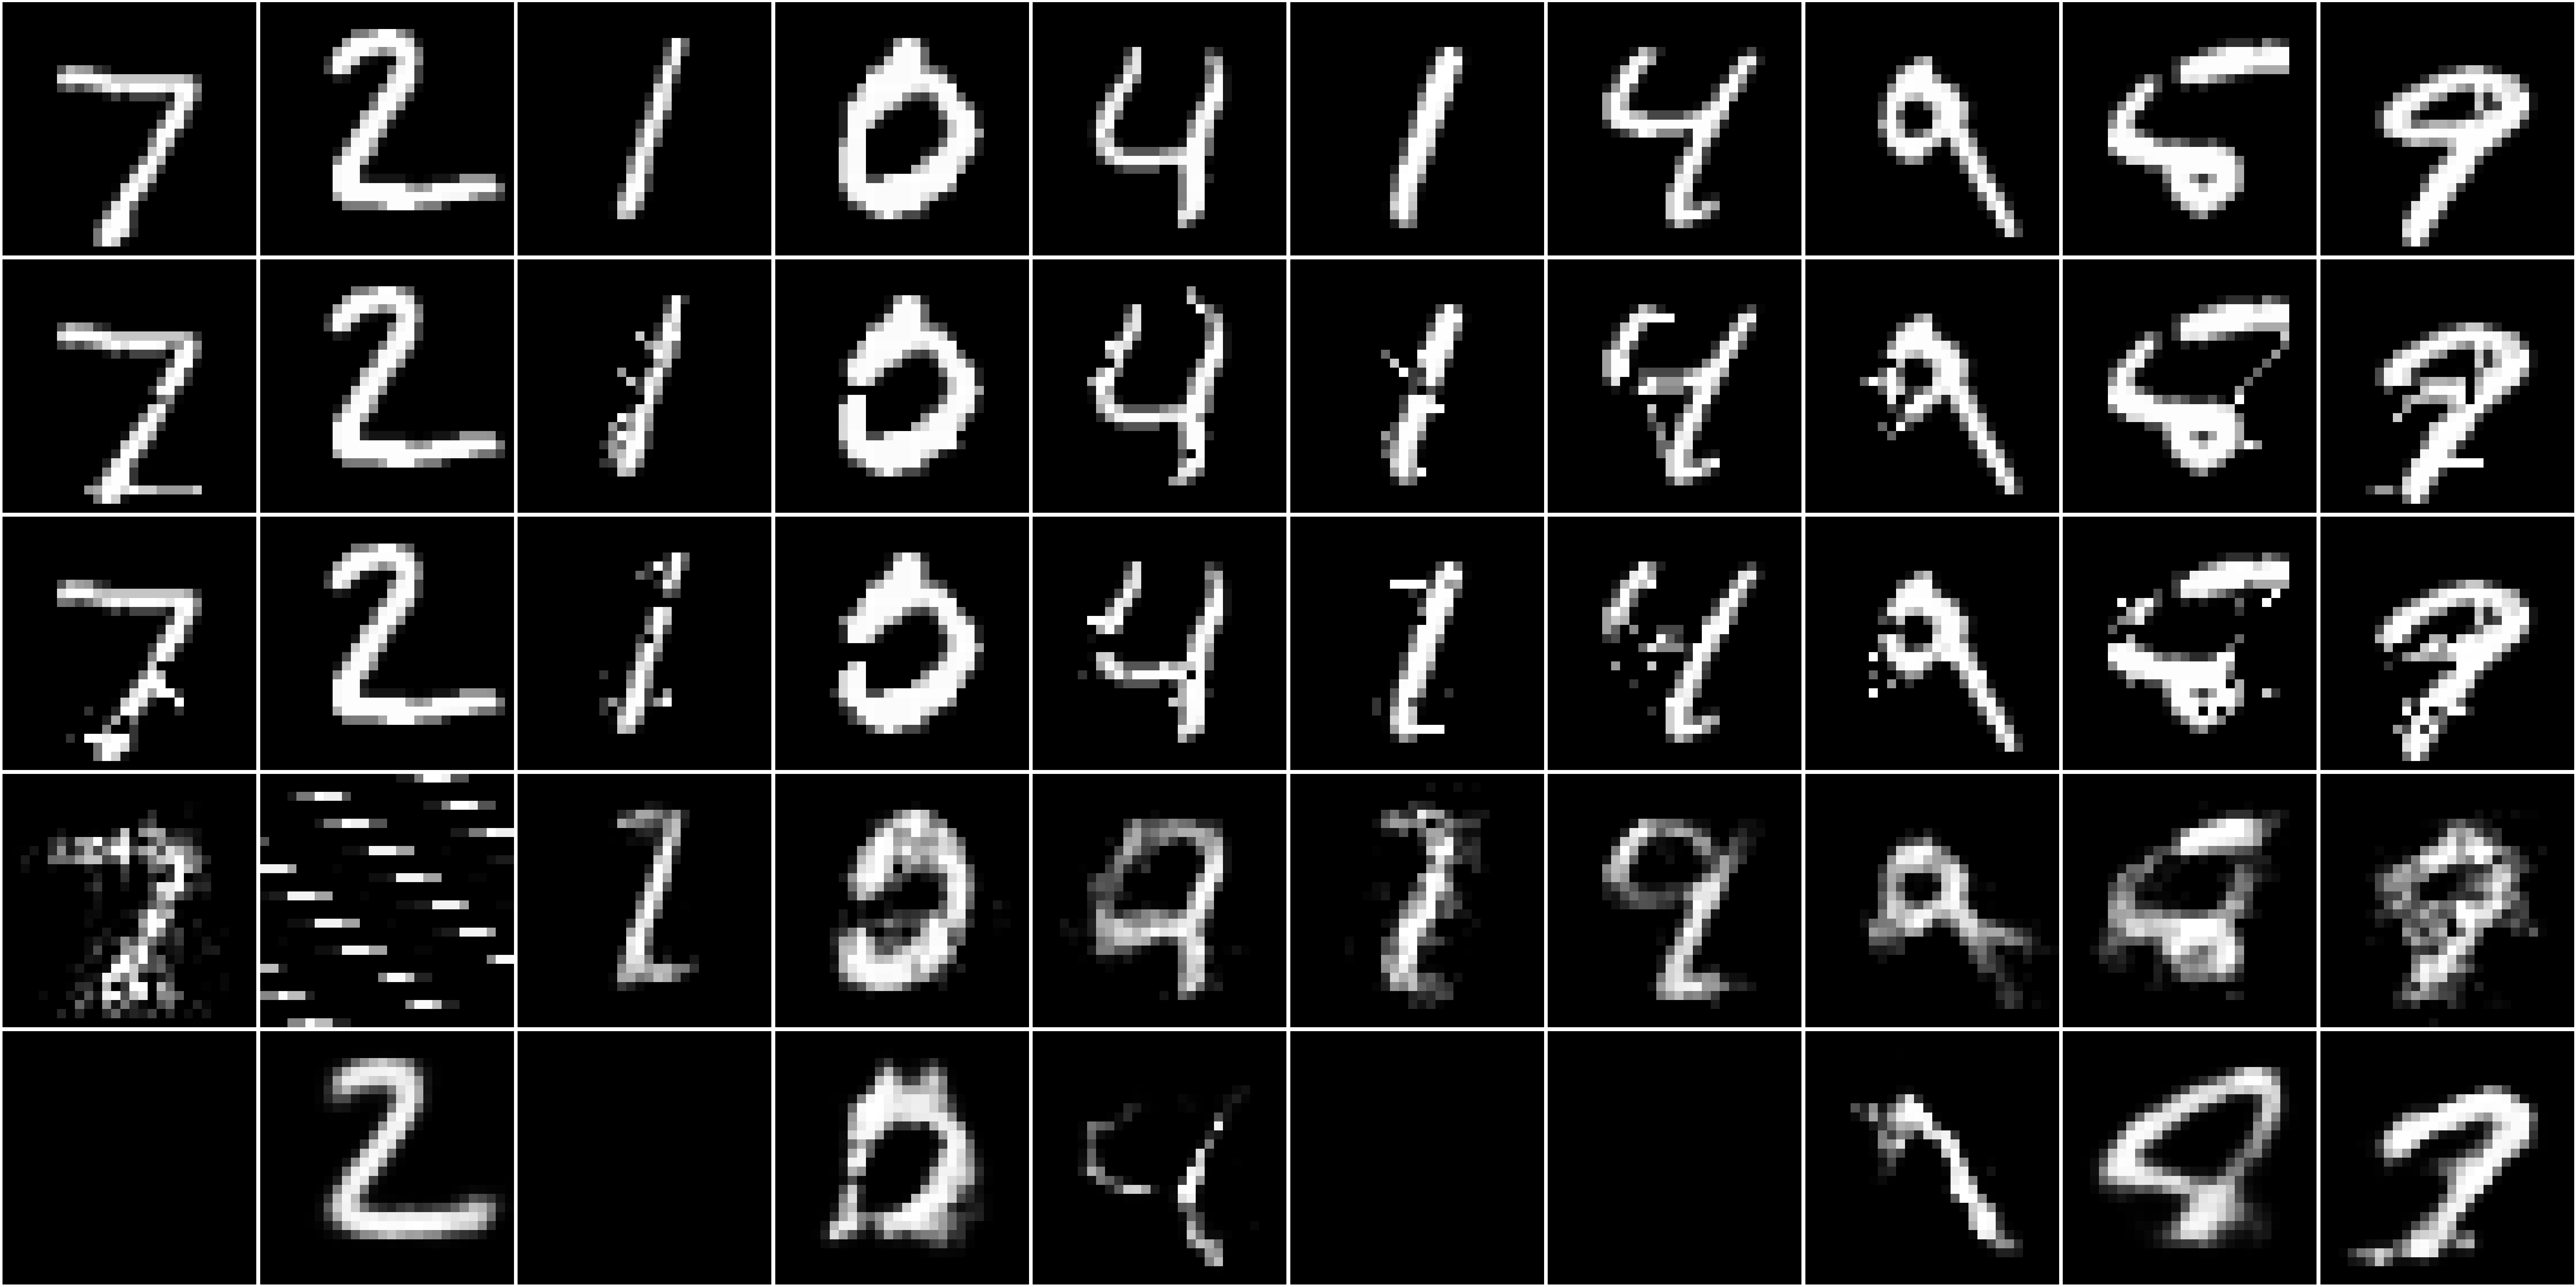

In [10]:
n_rows = len(GAN) + 1

def r2(x):
    return np.round(np.asarray(x), 2)


fig = plt.figure(figsize=(100, n_rows*10))
num=10

start = 0
target = 2

orig_GAN = []
for i in range(num):
    ax = plt.subplot2grid((n_rows,num), (0, i))
    plt.imshow(originals[start+i].view(28,28))
    plt.axis('off')
    orig_GAN.append(r2(GAN['DeDUCE'][start+i,labels[start+i]]))
print(orig_GAN)

k = 1
for method in GAN.keys():
  for i in range(num):
      ax = plt.subplot2grid((n_rows,num), (k, i))
      plt.imshow(im[method][start+i,target])
      plt.axis('off')
  print(r2(GAN[method][start:start+num, target]))
  k += 1
plt.tight_layout()

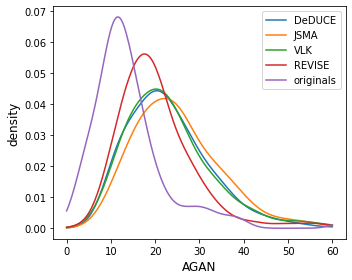

In [ ]:
#import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(5,4))
x_vals = np.linspace(0,60,200)
for alg in GAN.keys():
    density = gaussian_kde(GAN[alg][mask[alg]])
    density.covariance_factor = lambda : .3 #Smoothing parameter
    density._compute_covariance()
    plt.plot(x_vals,density(x_vals), label=alg)
density = gaussian_kde(GAN['DeDUCE'][targets == labels_exp])
density.covariance_factor = lambda : .3 #Smoothing parameter
density._compute_covariance()
plt.plot(x_vals,density(x_vals), label='originals')
plt.xlabel("AGAN", fontsize=12)
plt.ylabel("density", fontsize=12)
plt.legend()
plt.tight_layout()
#plt.savefig('distr_GAN.png')
plt.show()

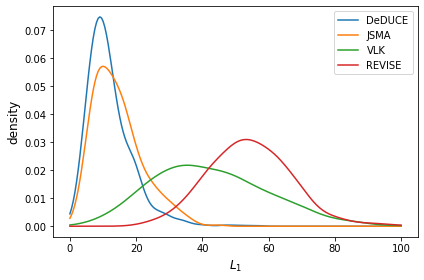

In [ ]:
fig, ax = plt.subplots()
x_vals = np.linspace(0,100,200)
for alg in GAN.keys():
    density = gaussian_kde(L1[alg][mask[alg]])
    density.covariance_factor = lambda : .3 #Smoothing parameter
    density._compute_covariance()
    plt.plot(x_vals,density(x_vals), label=alg)
plt.xlabel("$L_1$", fontsize=12)
plt.ylabel("density", fontsize=12)
plt.legend()
#plt.savefig('distr_L0.png')
plt.tight_layout()
plt.show()

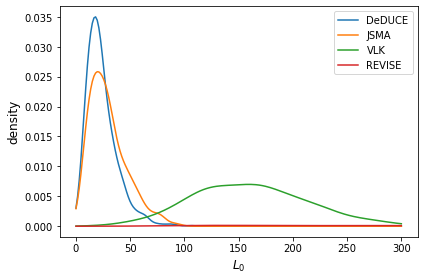

In [ ]:
fig, ax = plt.subplots()
x_vals = np.linspace(0,300,200)
for alg in GAN.keys():
    density = gaussian_kde(L0[alg][mask[alg]])
    density.covariance_factor = lambda : .3 #Smoothing parameter
    density._compute_covariance()
    plt.plot(x_vals,density(x_vals), label=alg)
plt.xlabel("$L_0$", fontsize=12)
plt.ylabel("density", fontsize=12)
plt.legend()
#plt.savefig('distr_L0.png')
plt.tight_layout()
plt.show()

In [11]:
def r2mean(x):
    return np.round(x.mean().item(), 2)
def r2std(x):
    return np.round(x.std().item(), 2)
    
print('originals GAN:', r2mean(GAN['DeDUCE'][labels_exp == targets]))

for alg in GAN.keys():
  ALIGN = '   ' if 'JSMA' in alg else ('    ' if 'VLK' in alg else ' ')
  print(alg, ALIGN, '   GAN: ', r2mean(GAN[alg][mask_all]),  '  L0: ', r2mean(L0[alg][mask_all].float()), '  L1: ', r2mean(L1[alg][mask_all]), '  good:', mask[alg].sum().item())
  
# STDs
print('STDs:')
for alg in GAN.keys():
  print(alg, '   GAN: ', r2std(GAN[alg][mask_all]), '  L0: ', r2std(L0[alg][mask_all].float()), '  L1: ', r2std(L1[alg][mask_all])) 

originals GAN: 14.18
DeDUCE      GAN:  22.69   L0:  21.13   L1:  10.74   good: 900
JSMA        GAN:  24.15   L0:  25.76   L1:  12.81   good: 876
VLK         GAN:  22.74   L0:  155.2   L1:  39.8   good: 896
REVISE      GAN:  20.56   L0:  747.93   L1:  54.29   good: 650
STDs:
DeDUCE    GAN:  9.72   L0:  11.55   L1:  5.42
JSMA    GAN:  9.64   L0:  14.41   L1:  6.23
VLK    GAN:  10.3   L0:  52.18   L1:  16.15
REVISE    GAN:  9.16   L0:  118.52   L1:  12.62


### t-tests

In [12]:
from scipy import stats

alg1 = 'VLK'
alg2 = 'DeDUCE'

mask_test = mask[alg1] & mask[alg2]

data1 = GAN[alg1][mask_test].float()
data2 = GAN[alg2][mask_test].float()

tStat, pValue = stats.ttest_rel(data1, data2) #run independent sample T-Test
print("P-Value: {0}   T-Statistic: {1}".format(pValue,tStat))
print(f'means: {data1.mean()} and {data2.mean()}')
print(f'stds: {data1.std()} and {data2.std()}')

P-Value: 0.9910270159633794   T-Statistic: 0.011249347040841153
means: 23.343358993530273 and 23.339235305786133
stds: 10.382733345031738 and 10.437320709228516


In [13]:
### differences
print((L0['DeDUCE'][mask_test] - L0['JSMA'][mask_test]).float().mean())
print((L0['DeDUCE'][mask_test] - L0['JSMA'][mask_test]).float().std())
print((L1['DeDUCE'][mask_test] - L1['JSMA'][mask_test]).mean())
print((L1['DeDUCE'][mask_test] - L1['JSMA'][mask_test]).std())
print((GAN['DeDUCE'][mask_test] - GAN['JSMA'][mask_test]).mean())
print((GAN['DeDUCE'][mask_test] - GAN['JSMA'][mask_test]).std())

tensor(-8.3125)
tensor(20.0273)
tensor(-4.2474)
tensor(12.9987)
tensor(-1.3556, dtype=torch.float64)
tensor(9.6979, dtype=torch.float64)


# individual label-target pairs for table

In [14]:
from CE.CE_utils import save_fig

def save_pair(intuple):
    
    i, target = intuple
    #save_fig(originals[i].view(28,28), f'im{i}_orig')
    
    for alg_id, alg in enumerate(['DeDUCE', 'JSMA', 'VLK', 'REVISE']):
        #save_fig(im[alg][i,target].view(28,28), f'im{i}_{target}_{alg_id}')
        
        #plt.imshow(im[alg][i,target].view(28,28))
        #plt.axis('off')
        #plt.show()
    
        ALIGN = '   ' if 'JSMA' in alg else ('    ' if 'VLK' in alg else ' ')
        print(f"id{i} {labels[i]}-to-{target} {alg} {ALIGN}:", 
              "{{{0}}}{{{1}}}{{{2}}}".format(r2(GAN[alg][i,target]), 
                                                    r2(L0[alg][i,target]), 
                                                    r2(L1[alg][i,target])))
    print('')

In [15]:
torch.manual_seed(0)
pairs = torch.randint(10,(8,2))
print(pairs)

tensor([[4, 9],
        [3, 0],
        [3, 9],
        [7, 3],
        [7, 3],
        [1, 6],
        [6, 9],
        [8, 6]])


In [16]:
for intuple in pairs.tolist():
  if labels[intuple[0]].cpu() != intuple[1]: # exclude cases where label=target
    save_pair(intuple)

id4 4-to-9 DeDUCE  : {14.01}{5}{3.200000047683716}
id4 4-to-9 JSMA    : {23.31}{29}{11.199999809265137}
id4 4-to-9 VLK     : {11.77}{60}{10.350000381469727}
id4 4-to-9 REVISE  : {15.13}{784}{31.90999984741211}

id3 0-to-9 DeDUCE  : {21.52}{18}{7.960000038146973}
id3 0-to-9 JSMA    : {22.32}{15}{10.390000343322754}
id3 0-to-9 VLK     : {56.81}{276}{81.19999694824219}
id3 0-to-9 REVISE  : {21.47}{784}{66.08999633789062}

id7 9-to-3 DeDUCE  : {25.55}{12}{6.75}
id7 9-to-3 JSMA    : {19.86}{19}{8.859999656677246}
id7 9-to-3 VLK     : {18.64}{141}{27.280000686645508}
id7 9-to-3 REVISE  : {27.41}{692}{57.630001068115234}

id7 9-to-3 DeDUCE  : {25.55}{12}{6.75}
id7 9-to-3 JSMA    : {19.86}{19}{8.859999656677246}
id7 9-to-3 VLK     : {18.64}{141}{27.280000686645508}
id7 9-to-3 REVISE  : {27.41}{692}{57.630001068115234}

id1 2-to-6 DeDUCE  : {22.82}{20}{9.199999809265137}
id1 2-to-6 JSMA    : {25.77}{35}{15.699999809265137}
id1 2-to-6 VLK     : {23.06}{177}{48.849998474121094}
id1 2-to-6 REVISE 

6 5


<Figure size 432x288 with 0 Axes>

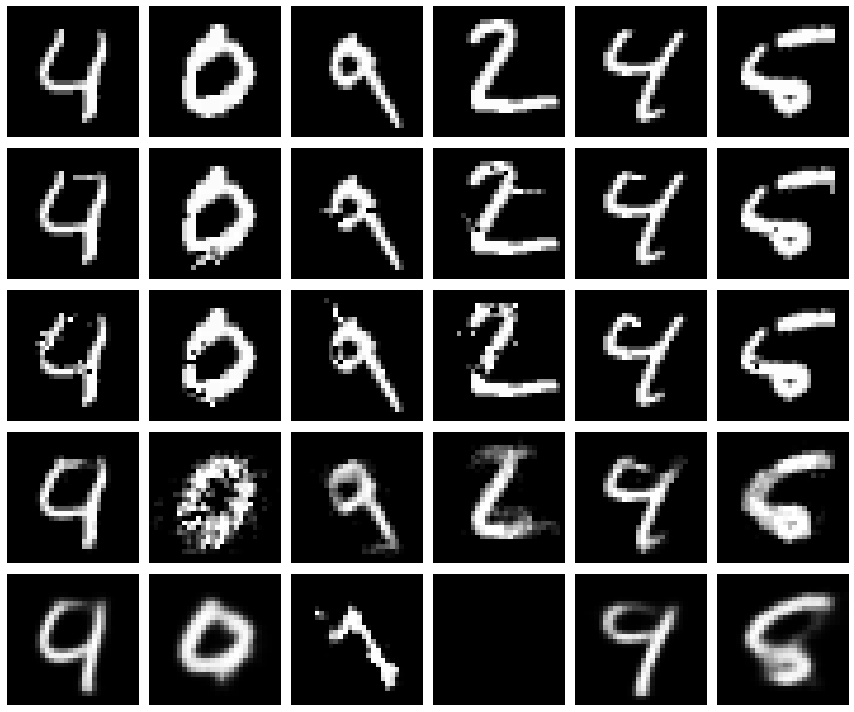

In [17]:
import matplotlib.pyplot as plt
plt.gray()

ids = [4,3,7,1,6,8] #easier to do manually: exclude double and target=label
tar = [9,9,3,6,9,6]

n_rows = len(GAN) + 1
n_cols = len(ids)

fig = plt.figure(figsize=(n_cols*2, n_rows*2))
print(n_cols, n_rows)

for i, idx in enumerate(ids):
    ax = plt.subplot2grid((n_rows,n_cols), (0, i),fig=fig)
    plt.imshow(originals[idx].view(28,28))
    plt.axis('off')

k=1
for method in GAN.keys():
  for i, idx in enumerate(ids):
      ax = plt.subplot2grid((n_rows,n_cols), (k, i))
      plt.imshow(im[method][idx,tar[i]])
      plt.axis('off')
  k += 1

plt.tight_layout()

# additional DeDUCE examples

In [ ]:
torch.manual_seed(0)
ids = torch.randint(10,100,(20,)).tolist()
targs = torch.randint(10,(20,)).tolist()
print(ids)
print(targs)

[54, 19, 93, 70, 53, 79, 17, 83, 47, 73, 81, 66, 16, 49, 38, 66, 46, 28, 24, 13]
[6, 9, 1, 4, 4, 1, 9, 9, 9, 0, 1, 2, 3, 0, 5, 5, 2, 9, 1, 8]


6 2


<Figure size 432x288 with 0 Axes>

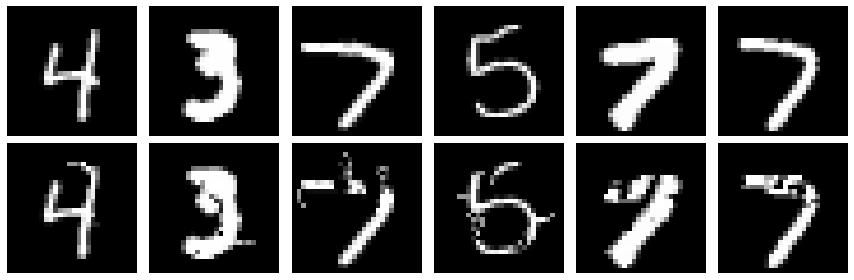

In [ ]:
import matplotlib.pyplot as plt
plt.gray()

n_rows = 2
n_cols = 6

fig = plt.figure(figsize=(n_cols*2, n_rows*2))
print(n_cols, n_rows)

for i in range(1,7): # first one has label=target=6
  ax = plt.subplot2grid((n_rows,n_cols), (0, i-1))
  plt.imshow(originals[ids[i]].view(28,28))
  plt.axis('off')
  # DeDUCE
  ax = plt.subplot2grid((n_rows,n_cols), (1, i-1))
  plt.imshow(im['DeDUCE'][ids[i],targs[i]])
  plt.axis('off')

plt.tight_layout()

6 2


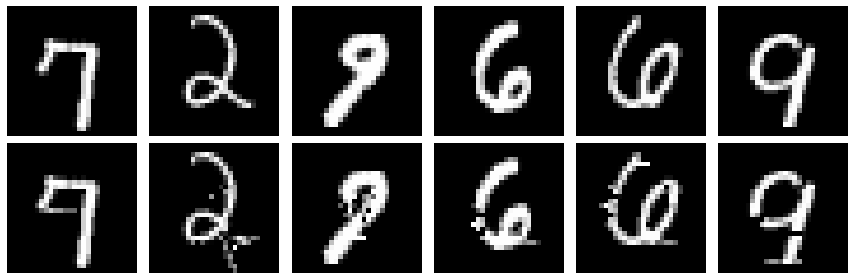

In [ ]:
fig = plt.figure(figsize=(n_cols*2, n_rows*2))
print(n_cols, n_rows)

for i in range(7,13):
  ax = plt.subplot2grid((n_rows,n_cols), (0, i-7))
  plt.imshow(originals[ids[i]].view(28,28))
  plt.axis('off')
  # DeDUCE
  ax = plt.subplot2grid((n_rows,n_cols), (1, i-7))
  plt.imshow(im['DeDUCE'][ids[i],targs[i]])
  plt.axis('off')

plt.tight_layout()

6 2


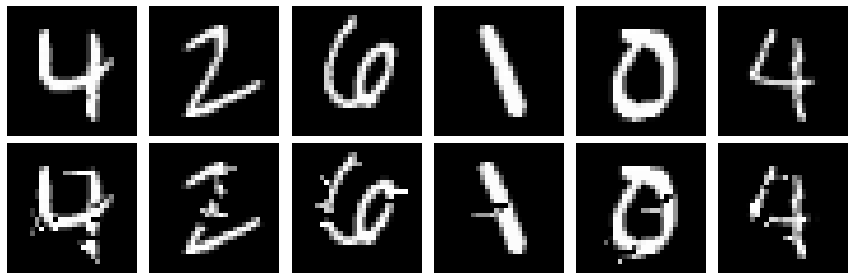

In [ ]:
fig = plt.figure(figsize=(n_cols*2, n_rows*2))
print(n_cols, n_rows)


for i in range(13,19):
  ax = plt.subplot2grid((n_rows,n_cols), (0, i-13))
  plt.imshow(originals[ids[i]].view(28,28))
  plt.axis('off')
  # DeDUCE
  ax = plt.subplot2grid((n_rows,n_cols), (1, i-13))
  plt.imshow(im['DeDUCE'][ids[i],targs[i]])
  plt.axis('off')

plt.tight_layout()